<div style="width: 100%; clear: both;">

<div style="float: left; width: 50%;">

<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">

</div>

<div style="float: right; width: 50%;">

<p style="margin: 0; padding-top: 22px; text-align:right;">M2.991 · Aprenentatge automàtic · PAC2</p>

<p style="margin: 0; text-align:right;">2024-1 · Màster universitari en Ciència de dades (Data science)</p>

<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>

</div>

</div>

<div style="width:100%;">&nbsp;</div>

# PAC 2: Aprenentatge no supervisat

En aquesta pràctica, explorarem l'ús de models de llenguatge grans (LLMs) per generar embeddings, aplicarem tècniques de reducció de dimensionalitat i utilitzarem diversos algorismes de clustering per analitzar el feedback de clients sobre l'empresa UPS obtingut de Yelp. En acabar, realitzarem una anàlisi detallada dels resultats obtinguts.

**Important:** cadascun dels exercicis pot suposar diversos minuts d'execució, per la qual cosa el lliurament s'ha de fer en format notebook i en format html, on es vegi el codi, els resultats i comentaris de cada exercici. Es pot exportar el notebook a html des del menú File $\to$ Download as $\to$ HTML.

**Important:** hi ha un tipus de cel·la especial per contenir text. Aquest tipus de cel·la us serà molt útil per respondre les diferents preguntes teòriques plantejades al llarg d'aquesta PAC. Per canviar el tipus de cel·la a aquest tipus, trieu al menú: Cell $\to$ Cell Type $\to$ Markdown.

**Important:** no oblideu posar el vostre nom i cognoms a la següent cel·la.

<div class="alert alert-block alert-info">
<strong>Nom i cognoms: Toni Vives Cabaleiro</strong>
</div>

Per a la realització de la pràctica necessitarem importar els següents mòduls:

In [1]:
import json
from typing import List

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, HDBSCAN, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tqdm
import umap
import pandas as pd

seed = 42

C:\Users\Usuario\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Càrrega del conjunt de dades i preprocessament (1,5 punts)

S'utilitzarà un dataset de comentaris de clients sobre l'empresa UPS recopilats de [Yelp](https://www.yelp.com/dataset), contingut en l'arxiu reviews_ups.txt, on cada línia és una review. Recordeu que pot haver-hi reviews sense contingut, les quals hauran de ser eliminades durant el preprocessament.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> carrega les opinions de l'arxiu en una llista i elimina aquelles opinions que estiguin literalment buides.
</div>

In [2]:
df = pd.read_json("reviews_stars_ups.json", lines=True)
df.head()

text  stars
0  I went to this location because it's easy to g...      5
1  It's just a place to get my mail. \nIt's about...      3
2  What a scam!  UPS stores charge $2.50 to 'for ...      1
3  Went to this store to get a passport sent to E...      1
4  This is not a review for all UPS Stores, but s...      4

In [3]:
df.isna().sum()

text     0
stars    0
dtype: int64

In [4]:
!pip install imbalanced-learn


Avui en dia, l'anàlisi de text en llenguatge natural ha estat revolucionat pels Models de Llenguatge Grans (LLMs), els quals han reemplaçat les tècniques clàssiques com TF-IDF i Bag of Words per a la representació de text. Aquestes tècniques clàssiques, tot i que útils, eren limitades en crear representacions disperses i poc contextuals dels textos. En canvi, els LLMs permeten generar representacions denses o embeddings, que capturen de manera molt més efectiva el significat semàntic de les paraules i les relacions entre elles.

Per comprendre com funcionen els models de llenguatge es recomana el següent vídeo que, al minut 12, explica visualment la part d'embeddings (representació vectorial de paraules o frases) que utilitzarem en la PAC: https://www.youtube.com/watch?v=wjZofJX0v4M

En aquesta pràctica, crearem una representació densa (embedding) de les reviews utilitzant MiniLM, un model lleuger que ofereix una excel·lent capacitat per generar embeddings de text mantenint un equilibri entre rendiment i eficiència computacional. MiniLM està basat en l'arquitectura Transformer, similar a altres models més grans com BERT, però optimitzat per ser més petit i ràpid, cosa que el fa ideal per a tasques com la nostra. En concret, utilitzarem la versió "all-MiniLM-L6-v2", que pots descarregar comprimida en un fitxer zip des del següent enllaç: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/v0.2/all-MiniLM-L6-v2.zip

Un cop descarregat l'arxiu, has de descomprimir-lo i col·locar el directori extret en el mateix directori on es troba aquest notebook, per facilitar-ne la càrrega.

Per carregar el model, utilitzarem la biblioteca sentence-transformers, que és una eina que facilita l'ús de models preentrenats per a la generació d'embeddings de text. Aquesta biblioteca està construïda sobre models com BERT, MiniLM, i altres, i ens permet, amb unes poques línies de codi, transformar frases i textos en representacions vectorials d'alta qualitat. Aquí pots trobar més documentació sobre sentence-transformers i el model en concret de MiniLM: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

En tenir el model descarregat en local només cal indicar el nom del directori descomprimit on es troba el model (que coincideix amb el nom del model).

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> carrega el model de MiniLM i crea l'embedding per a la frase "Estic resolent la PAC 2"
</div>

In [5]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  
frase = "Estic resolent la PAC 2"
embedding = model.encode(frase)
print("embedding = ", embedding)


embedding =  [-3.28027294e-03  9.02761146e-03  8.79593380e-03  4.49204957e-03
 -1.09555265e-02  3.78498919e-02 -9.98769980e-03  5.73650450e-02
  3.95285301e-02  2.57662646e-02  1.06923534e-02 -1.58949904e-02
 -4.30050828e-02 -2.46332381e-02  1.84600521e-02 -5.43837734e-02
 -3.41768712e-02  8.34198296e-03  1.21009452e-02 -1.74672641e-02
  8.00092891e-02 -6.34780824e-02 -3.30181867e-02  5.67536652e-02
 -8.63865241e-02 -3.15793237e-04  4.39975364e-03  3.19093056e-02
  9.64958221e-03 -9.40813571e-02 -2.25613508e-02  1.46912588e-02
  2.99515855e-02 -3.66251506e-02  2.61850702e-03 -2.37988378e-03
  7.35122338e-02 -1.08080506e-01  8.73353425e-03  6.89906329e-02
 -6.00013919e-02 -6.67898208e-02  4.77782264e-02 -7.64310034e-03
  7.10897334e-03 -1.34137692e-02  3.49888019e-02  1.01962611e-01
 -2.02165581e-02  2.58677881e-02  4.14751237e-03 -2.67684534e-02
 -2.32617538e-02  1.60293456e-03 -1.98684372e-02  7.44951470e-03
  6.73470125e-02  2.02235021e-02  6.36741146e-02 -3.67001398e-03
  6.89578727

Per crear els embeddings de cadascuna de les frases del dataset, hem de tenir en compte que aquest procés pot ser una mica més lent que algunes altres operacions, ja que implica transformar cada frase en una representació densa a través d'un model de llenguatge. Depenent de la mida del dataset i de la capacitat de la màquina, el temps requerit podria ser d'uns 5 minuts en una màquina estàndard. Tot i això, podem aplicar certes optimitzacions per accelerar aquest procés.

Una manera eficient de fer-ho és processar les frases en lots (batches) en lloc de processar-les una per una. La biblioteca sentence-transformers ens permet passar directament la llista completa de frases i dividir-les en lots més petits, fent que el càlcul dels embeddings sigui més ràpid aprofitant la capacitat de paral·lelització de la màquina. Per a això, podem utilitzar el paràmetre batch_size en el mètode `encode()`. Per exemple, si configurem `batch_size=256`, indicarem al model que processi 256 reviews al mateix temps, cosa que accelera el processament considerablement. Si el procés és molt lent, pots reduir aquest nombre perquè s'adapti a les característiques de la teva màquina.

A més, per poder fer un seguiment del progrés del càlcul, podem habilitar una barra de progrés amb el paràmetre `show_progress_bar=True`. Això ens permetrà tenir una visió clara de quant falta per completar el processament, cosa que és especialment útil quan treballem amb datasets grans.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> calcula l'embedding de totes les reviews (no buides)
</div>

In [6]:
embeddings = model.encode(df['text'].tolist(), batch_size=256, show_progress_bar=True)
df['embedding'] = list(embeddings)

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

In [7]:
df.head()

text  stars  \
0  I went to this location because it's easy to g...      5   
1  It's just a place to get my mail. \nIt's about...      3   
2  What a scam!  UPS stores charge $2.50 to 'for ...      1   
3  Went to this store to get a passport sent to E...      1   
4  This is not a review for all UPS Stores, but s...      4   

                                           embedding  
0  [0.011267502, -0.04679844, 0.052652907, 0.0478...  
1  [0.01855193, 0.0073932074, 0.04841725, 0.03587...  
2  [-0.09479127, 0.048495907, 0.007976261, -0.000...  
3  [-0.05758665, 0.040033754, 0.06722549, 0.02343...  
4  [-0.036489222, -0.0071466235, 0.0019362097, 0....

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Quantes dimensions té l'embedding generat per MiniLM?
</div>

In [8]:
embeddings.shape

(4485, 384)

podem observar com es generen 384 dimensions

## Reducció de dimensionalitat (2,5 punts)

L'embedding generat pel model té una alta dimensionalitat. Tot i que aquesta representació és ideal per capturar relacions semàntiques complexes entre frases, és difícil d'interpretar i visualitzar directament a causa de la gran quantitat de dimensions.

Per poder visualitzar els embeddings i entendre millor com es agrupen les reviews similars, necessitem reduir la dimensionalitat de l'espai a una cosa més manejable, com ara 2 dimensions. En fer-ho, podem representar gràficament les frases en un pla, cosa que ens permetrà identificar patrons, clusters de frases similars i relacions entre diferents opinions.

Pel que fa a la visualització, atès que tenim milers de punts (un per cada embedding generat), és important assegurar-nos que el gràfic no es torni confús o massa saturat. Per a això, utilitzarem un gràfic `scatter` de Matplotlib i aprofitarem el paràmetre `alpha=0.1`, que ajusta la transparència dels punts en el gràfic. Això ens permetrà visualitzar clarament les àrees més denses, ja que, on hi hagi una major concentració de punts, aquests se superposaran i es veuran més foscos, facilitant la identificació de zones amb alta densitat d'opinions similars.

### PCA (Principal Component Analysis)
PCA troba les direccions de major variància en les dades i projecta els punts cap a aquestes direccions. És ràpida i eficient, però cal tenir en compte que en alguns casos pot no capturar bé les relacions no lineals presents en els embeddings.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> redueix a 2 dimensions cadascuna de les reviews i visualitza el resultat on el color de cada punt es correspongui amb les estrelles d'aquesta review. Afegeix una llegenda per poder interpretar els colors.
</div>

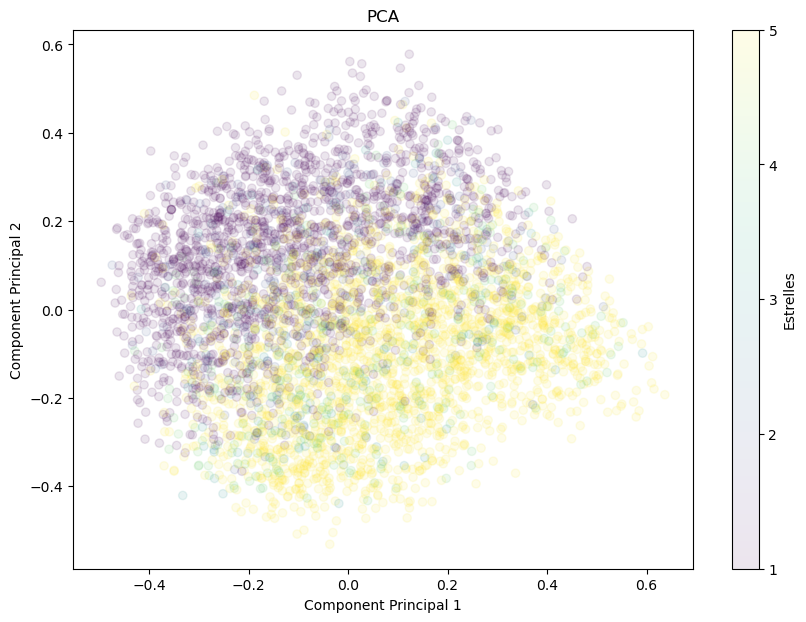

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

colors = df['stars']

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1],
                      c=colors, cmap="viridis", alpha=0.1)
plt.colorbar(scatter, label="Estrelles",ticks=[1, 2, 3, 4, 5])
plt.title("PCA")
plt.xlabel("Component Principal 1")
plt.ylabel("Component Principal 2")
plt.show()

### t-SNE (t-distributed Stochastic Neighbor Embedding)
t-SNE és una tècnica per reduir la dimensionalitat preservant les relacions locals (és a dir, manté els punts similars a prop els uns dels altres). Tot i que és més lenta que PCA, t-SNE no projecta linealment.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> redueix a 2 dimensions cadascuna de les reviews i visualitza el resultat on el color de cada punt es correspongui amb les estrelles d'aquesta review. Afegeix una llegenda per poder interpretar els colors.
</div>

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,learning_rate=200, perplexity=60, n_iter=1000,early_exaggeration=11, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)  


C:\Users\Usuario\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


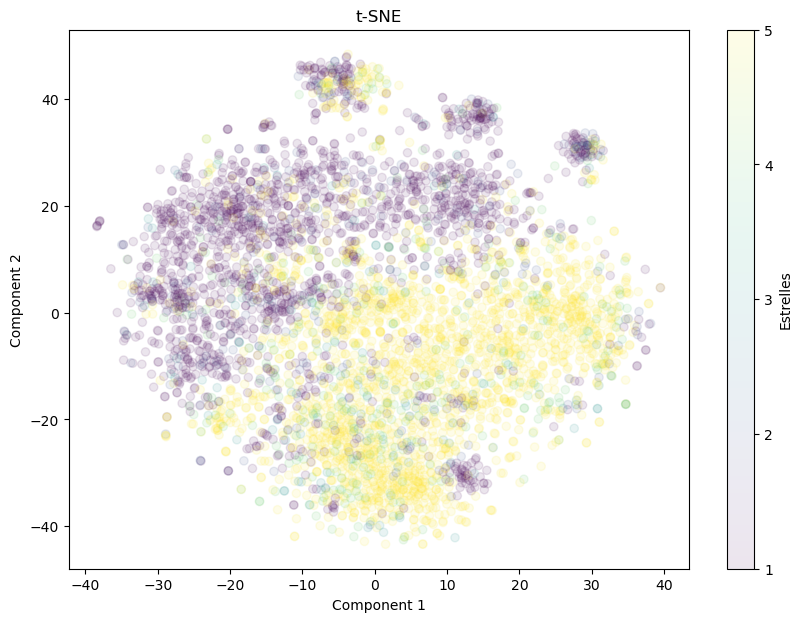

In [11]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1],
                      c=colors, cmap="viridis", alpha=0.1)
plt.colorbar(scatter, label="Estrelles",ticks=[1, 2, 3, 4, 5])
plt.title("t-SNE")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### UMAP (Uniform Manifold Approximation and Projection)
UMAP és una alternativa relativament nova que, igual que t-SNE, intenta mantenir les relacions locals, però sol ser més ràpida i permet una major flexibilitat per ajustar la precisió dels resultats.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> redueix a 2 dimensions cadascuna de les reviews i visualitza el resultat on el color de cada punt es correspongui amb les estrelles d'aquesta review. Afegeix una llegenda per poder interpretar els colors.
</div>

In [12]:
import umap

umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=5)
embeddings_umap = umap_model.fit_transform(embeddings) 



C:\Users\Usuario\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


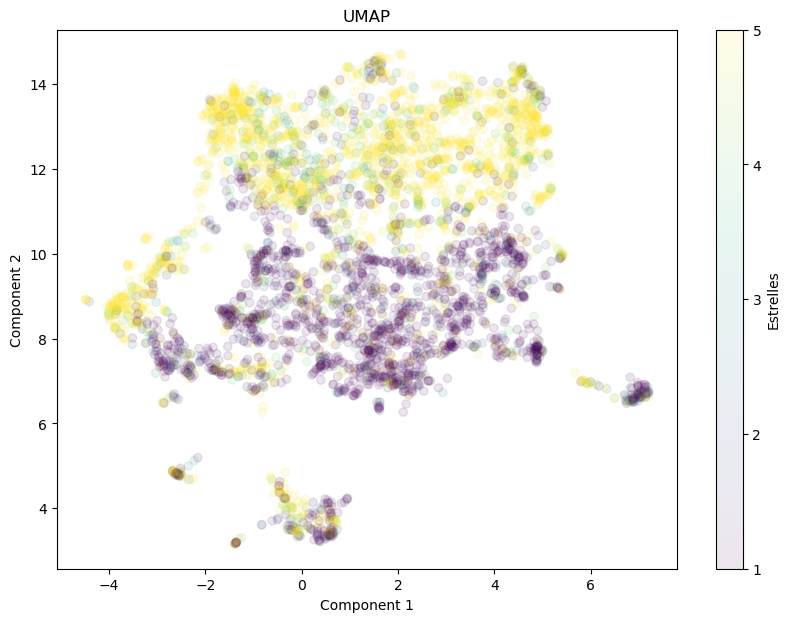

In [13]:

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1],
                      c=colors, cmap="viridis", alpha=0.1)
plt.colorbar(scatter, label="Estrelles",ticks=[1, 2, 3, 4, 5])
plt.title("UMAP")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Què has observat després de la seva aplicació? Tot i no haver utilitzat la informació de les estrelles en realitzar els embeddings, sembla que existeix una relació entre la disposició dels embeddings i el nombre d'estrelles?
</div>

En l'anàlisi de les valoracions de lliuraments d'UPS, els comentaris varien de 1 a 5 estrelles. **UMAP** destaca en agrupar clarament els comentaris d'1 i 5 estrelles, que són els més freqüents, mentre que els de 2 a 4 estrelles queden més dispersos. En comparació, el **PCA** mostra una visió més general de la distribució amb una dispersió uniforme, útil per entendre les variàncies principals però sense capturar bé les relacions no lineals o les agrupacions subtils. **T-SNE**, per la seva part, és eficaç en mostrar agrupacions locals entre els comentaris més extrems, però la seva alta demanda de recursos i la manca d'una funció de mapeig fixa limiten la seva utilitat en producció. En resum, mentre que el PCA és bo per a una visió inicial de les variàncies majors i t-SNE per a exploracions profundes, **UMAP ofereix el millor equilibri per anàlisis continuades en producció gràcies a la seva eficiència i consistència.**

Observant detingudament els gràfics, podem veure com queden tots els comentaris barrejats, per tant **no considero que hi hagi una clara relació entre els embeddings i el nombre d'estrelles.**

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Si haguessis de reduir la dimensionalitat per aplicar posteriorment un model d'aprenentatge supervisat que s'entrenarà una vegada i en producció farà prediccions diàries. Quins avantatges i desavantatges tindria cadascun dels mètodes? Per què?
</div>

A continuació, detallem els pros i contres de cada un d'aquests mètodes en aquest context específic:

### PCA (Anàlisi de Components Principals)
**Avantatges:**
- **Eficiència i rapidesa:** El PCA és computacionalment eficient, cosa que fa que sigui ràpid per a grans volums de dades.
- **Fàcil interpretació:** Els components principals sovint poden ser interpretats i entesos, cosa que ajuda a comprendre quines variables aporten més informació.
- **Consistència:** El PCA proporciona una transformació lineal consistent que pot ser aplicada a noves dades de manera fiable.

**Desavantatges:**
- **Limitació a linearitats:** El PCA només pot captar variàncies lineals entre les característiques i pot perdre's relacions més complexes.
- **Sensibilitat a l'escalat:** Les variàncies estan influenciades per l'escala de les característiques, així que diferents escalats poden produir resultats diferents.

### t-SNE (t-Distributed Stochastic Neighbor Embedding)
**Avantatges:**
- **Visualització excel·lent:** t-SNE és excepcional per a la visualització de dades complexes en dimensions baixes.
- **Descobriment de clústers:** És capaç de descobrir clústers de dades en espais multidimensionals de manera efectiva.

**Desavantatges:**
- **No és consistent:** Les sortides de t-SNE no són consistents entre diferents execucions, dificultant la seva aplicació en un entorn de producció on es necessita consistència.
- **Cost computacional alt:** t-SNE pot ser molt lent amb grans datasets i no escala bé amb l'augment de la mida del dataset.
- **Falta de mapeig explícit:** No genera una funció de mapeig fixa per a aplicar als nous punts de dades, la qual cosa el fa inadequat per a prediccions en un model de producció.

### UMAP (Uniform Manifold Approximation and Projection)
**Avantatges:**
- **Bon equilibri entre estructura local i global:** UMAP conserva les distàncies locals i, en menor mesura, les globals, cosa que proporciona una bona visió general i detallada de les dades.
- **Eficient en recursos:** Més ràpid i eficient en termes de memòria que t-SNE, i es comporta bé amb grans volums de dades.
- **Aplicable a noves dades:** UMAP pot generalitzar a noves dades una vegada entrenat, el que és crucial per a models en producció.

**Desavantatges:**
- **Complexitat en la selecció de paràmetres:** Calibrar els paràmetres correctament pot ser difícil i pot influir molt en els resultats.
- **Menys interpretable que PCA:** Tot i que els resultats poden ser útils, no són tan fàcilment interpretables com els del PCA.


### Validació en 3 dimensions

Després de visualitzar la reducció a dues dimensions, tria el mètode de reducció de dimensionalitat que consideris més adequat. A continuació, valida que les estructures identificades es mantenen en estendre la visualització a tres dimensions. Aquesta validació permet afegir més informació i verificar si els patrons observats persisteixen quan s'incorpora una dimensió addicional, la qual cosa proporciona una visió més completa de l'organització de les dades.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> crea un nou embedding projectant a 3 dimensions amb el mètode triat i visualitza amb matplotlib mantenint el color com a indicatiu del nombre d'estrelles de cada review.
</div>

In [14]:

umap_model_3d = umap.UMAP(n_components=3, random_state=42)
embeddings_umap_3d = umap_model_3d.fit_transform(embeddings)  


C:\Users\Usuario\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


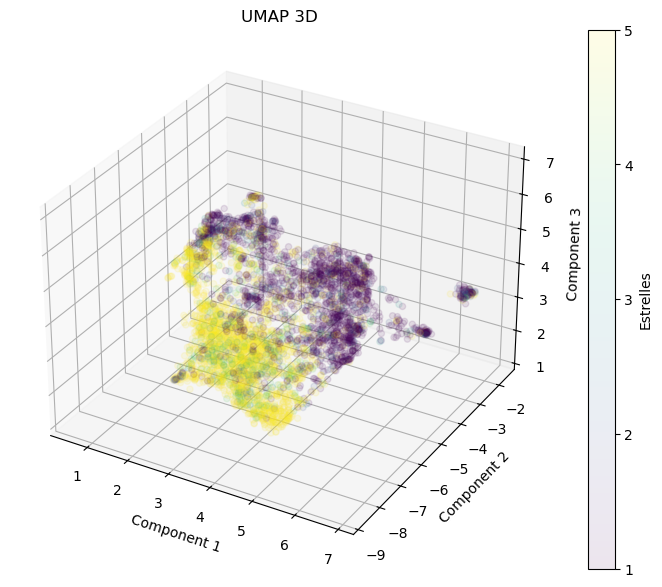

In [15]:
# Crear el gràfic scatter en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_umap_3d[:, 0], embeddings_umap_3d[:, 1], embeddings_umap_3d[:, 2],
                     c=colors, cmap='viridis', alpha=0.1)
cbar = fig.colorbar(scatter, ax=ax, ticks=[1, 2, 3, 4, 5])
cbar.set_label("Estrelles")

# Configurar etiquetes i títol
ax.set_title("UMAP 3D")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> És coherent aquesta visualització amb el que s'ha observat a la figura 2d?
</div>

La visualització 3D que he creat mantenint UMAP com a mètode de reducció de dimensionalitat és coherent amb la figura 2D anterior. En ambdós casos, la distribució dels punts segueix un patró similar en quant a l'agrupació segons el nombre d'estrelles de cada comentari. Encara que els eixos en la visualització 3D mostren diferents valors degut a l'afegiment de la dimensió extra, això no altera l'estructura fonamental observada en el gràfic 2D.

### Dendrograma

A més de la visualització de les dades en 2 dimensions mitjançant mètodes de reducció de dimensionalitat, també podem intentar entendre com es distribueixen els punts en l'espai d'alta dimensionalitat utilitzant una tècnica diferent: el **dendrograma**.

Un dendrograma és una **representació gràfica que mostra l'estructura jeràrquica d'un conjunt de dades**. Aquest tipus de gràfic és especialment útil per entendre les relacions entre punts de dades quan volem agrupar-los de manera jeràrquica. El dendrograma es genera com a part de l'algorisme de clustering jeràrquic, el qual intenta agrupar les dades de manera recursiva, creant una estructura en forma d'arbre on cada fulla representa un punt del dataset i cada bifurcació representa la unió de dos grups.

Com interpretar un dendrograma:

A la part inferior del dendrograma, cada fulla representa una dada individual (en aquest cas, una review).
- A mesura que ens movem cap amunt, els punts que estan més propers entre si es van agrupant, i aquests grups s'uneixen en nivells superiors fins que, eventualment, tots els punts es junten en un únic grup a la part superior.
- Les distàncies verticals indiquen la similitud o dissimilitud entre els grups que s'estan unint. Com més gran és l'altura a la qual s'uneixen dos grups, més gran és la dissimilitud entre ells. Per tant, un dendrograma ens dóna una idea visual de quins punts estan més a prop els uns dels altres i com els clusters més petits es fusionen per formar clusters més grans.
- Utilitzant un dendrograma, podem decidir quants clusters té sentit crear, observant on seria adequat tallar l'arbre. Per exemple, si trobem un punt on els grups comencen a unir-se amb una gran distància, això podria indicar que és un bon lloc per tallar i definir el nombre de clusters.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> visualitza el dendrograma tenint en compte aquests paràmetres:
<ul>
<li><strong>truncate_mode='level'</strong>: limita la profunditat del dendrograma, mostrant només un nombre determinat de nivells d'unió, cosa que és útil per evitar un gràfic excessivament complex.

<li><strong>p=200</strong>: quants clusters o nivells es mostraran. En aquest cas, es visualitzaran fins a 500 grups, permetent un bon equilibri entre detall i simplicitat.

<li><strong>no_labels=True</strong>: oculta les etiquetes de cada punt per evitar que el gràfic es vegi sobrecarregat i es generi més ràpidament.

<li><strong>method='single'</strong>: és una manera intuïtiva d'agrupar les mostres, ja que defineix la distància entre dos grups com la distància entre els punts més propers de cada grup.
</ul>
</div>

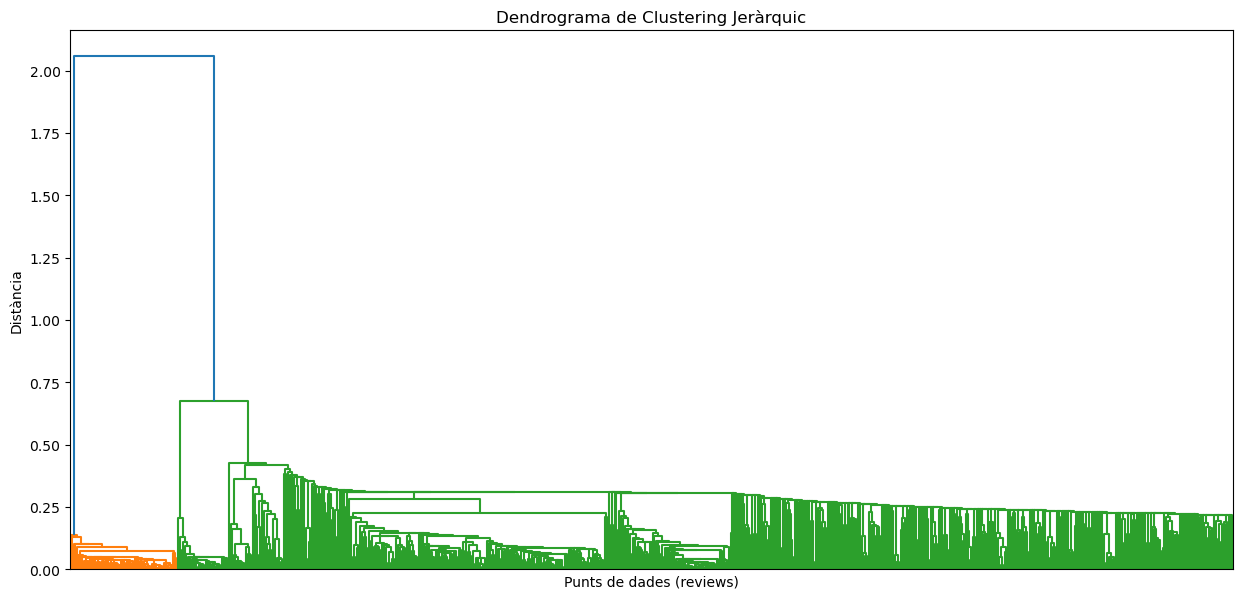

In [30]:
data = embeddings_umap_3d
#data = embeddings_pca
# Generar el linkage per al clustering jeràrquic
linkage_matrix = linkage(data, method='single')

# Crear el dendrograma amb els paràmetres especificats
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, truncate_mode='level', p=200, no_labels=True)
plt.title("Dendrograma de Clustering Jeràrquic")
plt.xlabel("Punts de dades (reviews)")
plt.ylabel("Distància")
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Què podem observar en el dendrograma? Hi ha alguna cosa semblant a l'observat en les reduccions de dimensionalitat?
</div>

Podem observar que, igual que en les altres visualitzacions, hi ha dos grups que es poden diferenciar amb facilitat. Un d’aquests grups es manté compacte, mentre que l’altre és més dispers i es barreja amb altres punts, reflectint una major variabilitat interna. Aquesta dispersió suggereix que dins d'aquest segon grup hi ha subgrups menys definits, amb més diversitat en les característiques de les reviews.

## Clustering (3 punts)

Després d'haver visualitzat el conjunt de dades i examinat el dendrograma, hem obtingut una visió més profunda sobre l'estructura i les relacions internes del dataset. Aquesta informació ens ajudarà a prendre una decisió informada sobre quina és la millor estratègia de clustering a seguir. Tanmateix, abans de definir la nostra estratègia final, és important explorar com funcionen diferents algorismes de clustering, per comprendre millor els seus avantatges i limitacions.

En aquest context, realitzarem alguns experiments utilitzant diferents algorismes de clustering. Provarem enfocaments com **K-means**, **clustering jeràrquic**, **DBSCAN**, i **Mean-Shift**.

Per a això, comptem amb els següents datasets:

In [17]:
n_samples = 1000
blobs_data, blobs_labels = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=seed)
moons_data, moons_labels = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
circles_data, circles_labels = datasets.make_circles(n_samples=n_samples, factor=0.4, noise=0.05, random_state=seed)

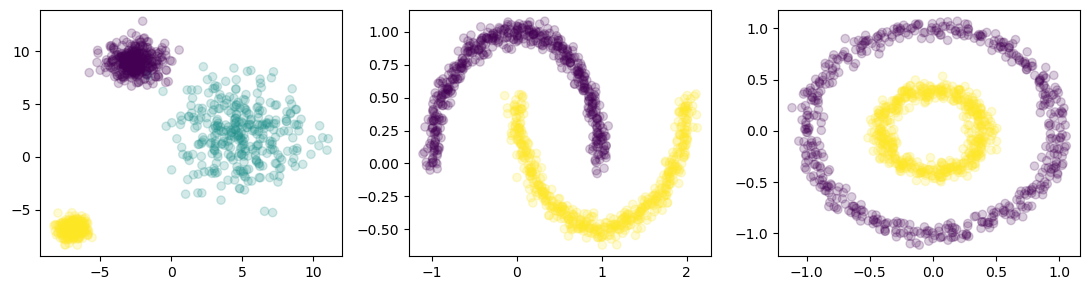

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(11, 3))
ax[0].scatter(blobs_data[:,0], blobs_data[:,1], c=blobs_labels, alpha=.2)
ax[1].scatter(moons_data[:,0], moons_data[:,1], c=moons_labels, alpha=.2)
ax[2].scatter(circles_data[:,0], circles_data[:,1], c=circles_labels, alpha=.2)
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> aplica K-means als tres datasets anteriors i visualitza el seu resultat.
</div>

C:\Users\Usuario\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Usuario\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Usuario\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


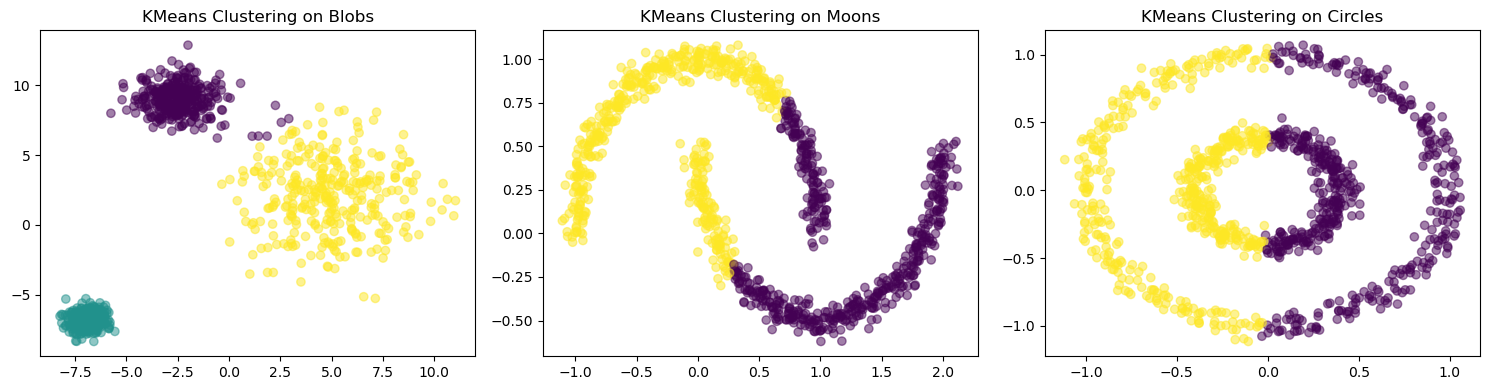

In [19]:
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

kmeans_blobs = KMeans(n_clusters=3, random_state=seed).fit(blobs_data)
kmeans_moons = KMeans(n_clusters=2, random_state=seed).fit(moons_data)
kmeans_circles = KMeans(n_clusters=2, random_state=seed).fit(circles_data)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(blobs_data[:, 0], blobs_data[:, 1], c=kmeans_blobs.labels_, cmap='viridis', alpha=0.5)
ax[0].set_title("KMeans Clustering on Blobs")

ax[1].scatter(moons_data[:, 0], moons_data[:, 1], c=kmeans_moons.labels_, cmap='viridis', alpha=0.5)
ax[1].set_title("KMeans Clustering on Moons")

ax[2].scatter(circles_data[:, 0], circles_data[:, 1], c=kmeans_circles.labels_, cmap='viridis', alpha=0.5)
ax[2].set_title("KMeans Clustering on Circles")

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info">
<strong>Implementació:</strong> aplica clustering jeràrquic als tres datasets anteriors i visualitza el seu resultat.
</div>

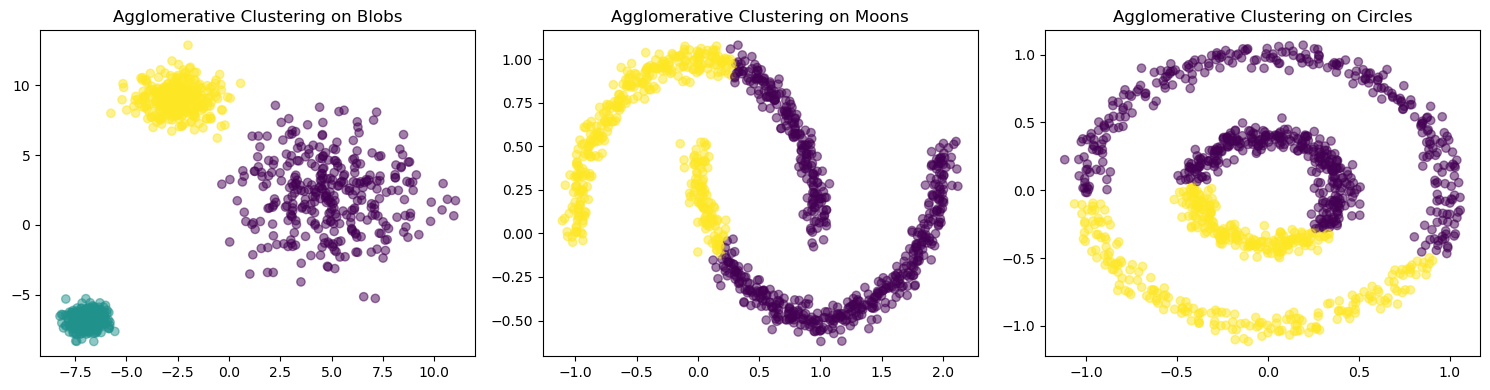

In [20]:
agg_clustering_blobs = AgglomerativeClustering(n_clusters=3).fit(blobs_data)
agg_clustering_moons = AgglomerativeClustering(n_clusters=2).fit(moons_data)
agg_clustering_circles = AgglomerativeClustering(n_clusters=2).fit(circles_data)


fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(blobs_data[:, 0], blobs_data[:, 1], c=agg_clustering_blobs.labels_, cmap='viridis', alpha=0.5)
ax[0].set_title("Agglomerative Clustering on Blobs")

ax[1].scatter(moons_data[:, 0], moons_data[:, 1], c=agg_clustering_moons.labels_, cmap='viridis', alpha=0.5)
ax[1].set_title("Agglomerative Clustering on Moons")

ax[2].scatter(circles_data[:, 0], circles_data[:, 1], c=agg_clustering_circles.labels_, cmap='viridis', alpha=0.5)
ax[2].set_title("Agglomerative Clustering on Circles")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> aplica DBSCAN als tres datasets anteriors i visualitza el seu resultat.
</div>

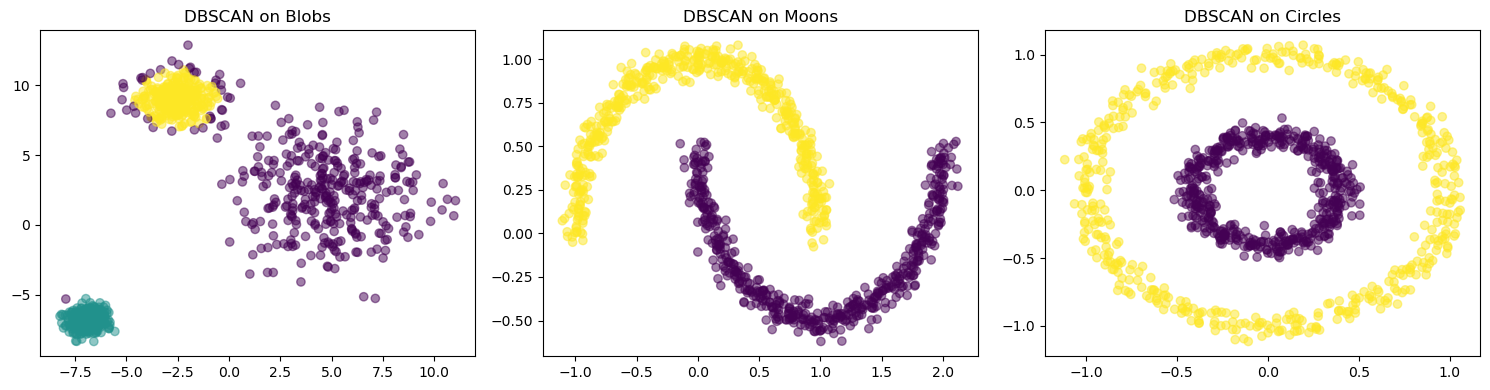

In [21]:
dbscan_blobs = DBSCAN(eps=0.8, min_samples=45).fit(blobs_data)
dbscan_moons = DBSCAN(eps=0.2, min_samples=5).fit(moons_data)
dbscan_circles = DBSCAN(eps=0.2, min_samples=5).fit(circles_data)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(blobs_data[:, 0], blobs_data[:, 1], c=dbscan_blobs.labels_, cmap='viridis', alpha=0.5)
ax[0].set_title("DBSCAN on Blobs")

ax[1].scatter(moons_data[:, 0], moons_data[:, 1], c=dbscan_moons.labels_, cmap='viridis', alpha=0.5)
ax[1].set_title("DBSCAN on Moons")

ax[2].scatter(circles_data[:, 0], circles_data[:, 1], c=dbscan_circles.labels_, cmap='viridis', alpha=0.5)
ax[2].set_title("DBSCAN on Circles")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> aplica Mean-shift als tres datasets anteriors i visualitza el seu resultat.
</div>

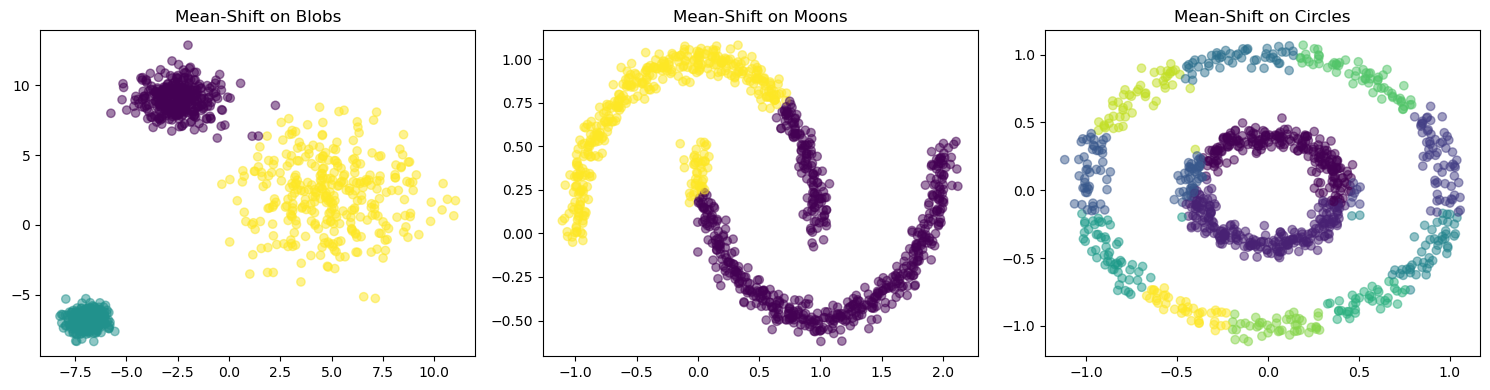

In [54]:
from sklearn.cluster import estimate_bandwidth

bandwidth_blobs = estimate_bandwidth(blobs_data,quantile=0.3)
bandwidth_moons = estimate_bandwidth(moons_data,quantile=0.22)
bandwidth_circles = estimate_bandwidth(circles_data,quantile=0.12)

mean_shift_blobs = MeanShift(bandwidth=bandwidth_blobs).fit(blobs_data)
mean_shift_moons = MeanShift(bandwidth=bandwidth_moons).fit(moons_data)
mean_shift_circles = MeanShift(bandwidth=bandwidth_circles).fit(circles_data)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(blobs_data[:, 0], blobs_data[:, 1], c=mean_shift_blobs.labels_, cmap='viridis', alpha=0.5)
ax[0].set_title("Mean-Shift on Blobs")

ax[1].scatter(moons_data[:, 0], moons_data[:, 1], c=mean_shift_moons.labels_, cmap='viridis', alpha=0.5)
ax[1].set_title("Mean-Shift on Moons")

ax[2].scatter(circles_data[:, 0], circles_data[:, 1], c=mean_shift_circles.labels_, cmap='viridis', alpha=0.5)
ax[2].set_title("Mean-Shift on Circles")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> En quins casos no s'ha pogut ajustar el resultat del model als clusters originals? Per què?
</div>

En aplicar els mètodes de clustering K-means, Clustering Jeràrquic, DBSCAN i Mean-Shift als datasets de `blobs`, `moons` i `circles`, observem resultats variats que depenen de les característiques inherents de cada mètode i les propietats dels datasets:

1. **K-Means** funciona bé amb els `blobs` que són linealment separables i tenen una distribució simètrica. No obstant això, aquest mètode fracassa amb els `moons` i els `circles` a causa de la seva suposició de clusters esfèrics i centrats, la qual cosa el fa incapaç de reconèixer formes concèntriques o en formes de mitjes llunes.

2. **Clustering Jeràrquic** també pot ser efectiu amb els `blobs`, especialment si s'escull un mètode d'enllaç adequat. Però igual que K-Means, pot tenir dificultats amb els `moons` i `circles` si s'utilitza una mètrica basada en la distància euclidiana, que no adapta bé a les formes dels datasets.

3. **DBSCAN** destaca per la seva capacitat per ajustar-se a la densitat dels clusters, cosa que el fa particularment efectiu per als `moons` i `circles` on altres mètodes fallen. Amb una selecció adequada de `eps` i `min_samples`, DBSCAN pot identificar correctament els grups de dades, independentment de la seva forma geomètrica.

4. **Mean-Shift**, similar a DBSCAN, és adaptable gràcies a la seva dependència de la densitat dels punts més que de la seva distància euclidiana. Tot i això, el seu rendiment és molt sensible a l'ajust del paràmetre `bandwidth`. Un `bandwidth` ben triat pot permetre a Mean-Shift funcionar bé en tots els tipus de datasets, però un mal ajust pot portar a resultats pobres, especialment en dades amb formes complexas com `moons` i `circles`.

En conclusió, mentre K-Means i Clustering Jeràrquic són més adequats per a dades uniformement distribuïdes com els `blobs`, DBSCAN i Mean-Shift ofereixen una major flexibilitat i robustesa en front a dades amb distribucions irregulars o no convencionals. La selecció del mètode de clustering adequat depèn en gran mesura de la naturalesa del dataset a analitzar.


In [55]:

dbscan_embeddings = DBSCAN(eps=0.2, min_samples=5).fit(embeddings_pca)
agg_clustering_embeddings = AgglomerativeClustering(n_clusters=5).fit(embeddings_pca)
kmeans_embeddings = KMeans(n_clusters=5, random_state=seed).fit(embeddings_pca)
bandwidth_embeddings = estimate_bandwidth(embeddings_pca,quantile=0.12)
mean_shift= MeanShift(bandwidth=bandwidth_embeddings).fit(embeddings_pca)


C:\Users\Usuario\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(


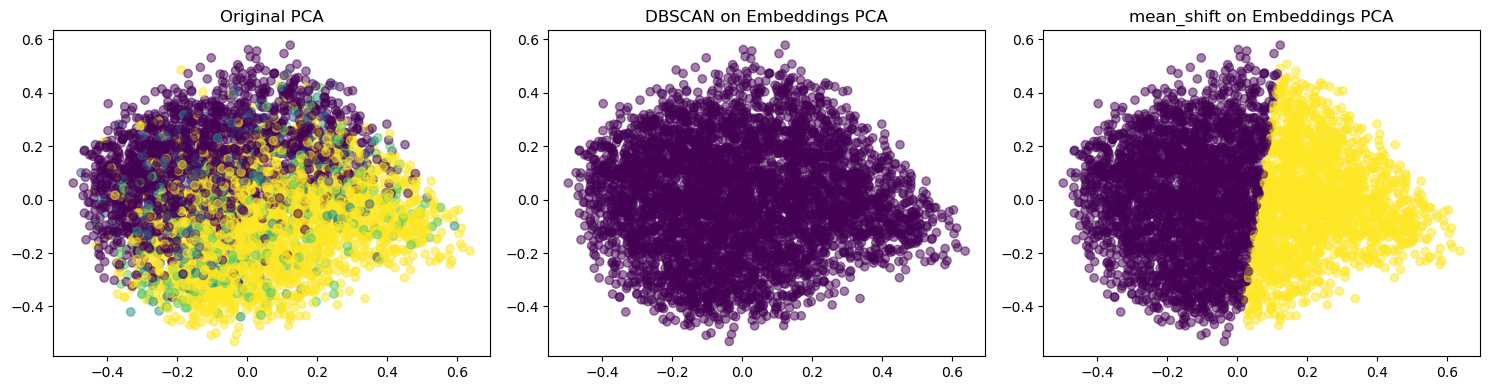

In [58]:

# Step 2: Plot each clustering result
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

embeddings_to_show = embeddings_pca
# DBSCAN plot
ax[0].scatter(embeddings_to_show[:, 0], embeddings_to_show[:, 1], c=colors, cmap='viridis', alpha=0.5)
ax[0].set_title("Original PCA")
# DBSCAN plot
ax[1].scatter(embeddings_to_show[:, 0], embeddings_to_show[:, 1], c=dbscan_embeddings.labels_, cmap='viridis', alpha=0.5)
ax[1].set_title("DBSCAN on Embeddings PCA")

# KMeans plot
ax[2].scatter(embeddings_to_show[:, 0], embeddings_to_show[:, 1], c=mean_shift.labels_, cmap='viridis', alpha=0.5)
ax[2].set_title("mean_shift on Embeddings PCA")

plt.tight_layout()
plt.show()

C:\Users\Usuario\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(


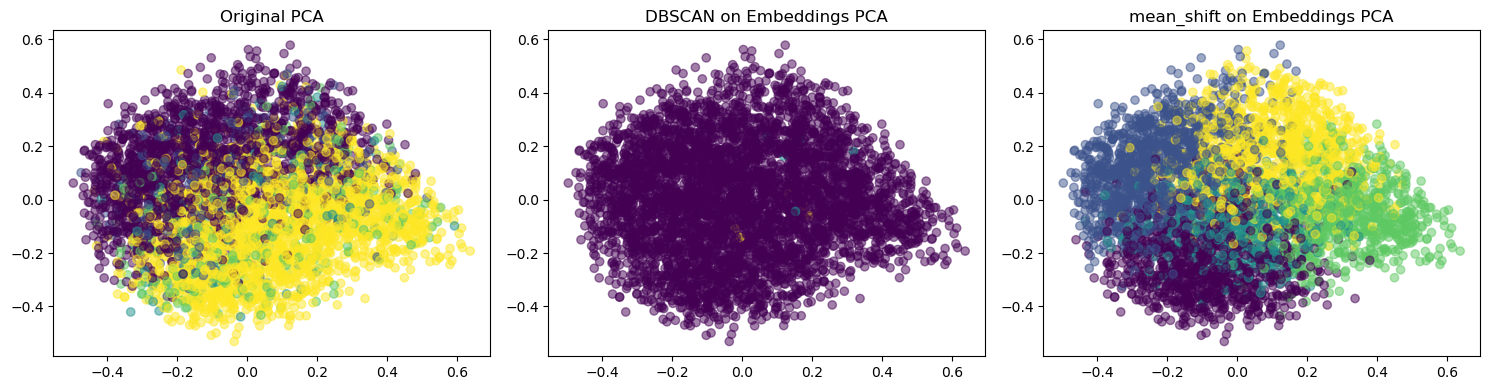

In [59]:

dbscan_embeddings = DBSCAN(eps=0.2, min_samples=5).fit(embeddings_tsne)
bandwidth_embeddings = estimate_bandwidth(embeddings_tsne,quantile=0.12)
mean_shift= MeanShift(bandwidth=bandwidth_embeddings).fit(embeddings_tsne)

# Step 2: Plot each clustering result
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

embeddings_to_show = embeddings_pca
# DBSCAN plot
ax[0].scatter(embeddings_to_show[:, 0], embeddings_to_show[:, 1], c=colors, cmap='viridis', alpha=0.5)
ax[0].set_title("Original PCA")
# DBSCAN plot
ax[1].scatter(embeddings_to_show[:, 0], embeddings_to_show[:, 1], c=dbscan_embeddings.labels_, cmap='viridis', alpha=0.5)
ax[1].set_title("DBSCAN on Embeddings PCA")

# KMeans plot
ax[2].scatter(embeddings_to_show[:, 0], embeddings_to_show[:, 1], c=mean_shift.labels_, cmap='viridis', alpha=0.5)
ax[2].set_title("mean_shift on Embeddings PCA")

plt.tight_layout()
plt.show()

C:\Users\Usuario\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(


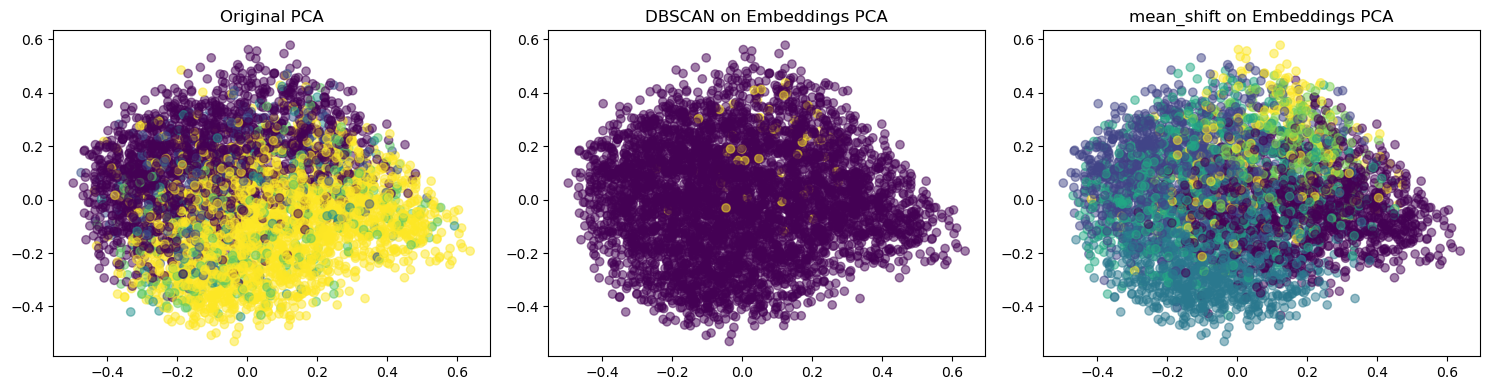

In [60]:

dbscan_embeddings = DBSCAN(eps=0.2, min_samples=50).fit(embeddings_umap)
agg_clustering_embeddings = AgglomerativeClustering(n_clusters=5).fit(embeddings_umap)
kmeans_embeddings = KMeans(n_clusters=5, random_state=seed).fit(embeddings_umap)
bandwidth_embeddings = estimate_bandwidth(embeddings_umap,quantile=0.12)
mean_shift= MeanShift(bandwidth=bandwidth_embeddings).fit(embeddings_umap)

# Step 2: Plot each clustering result
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

embeddings_to_show = embeddings_pca
# DBSCAN plot
ax[0].scatter(embeddings_to_show[:, 0], embeddings_to_show[:, 1], c=colors, cmap='viridis', alpha=0.5)
ax[0].set_title("Original PCA")
# DBSCAN plot
ax[1].scatter(embeddings_to_show[:, 0], embeddings_to_show[:, 1], c=dbscan_embeddings.labels_, cmap='viridis', alpha=0.5)
ax[1].set_title("DBSCAN on Embeddings PCA")

# KMeans plot
ax[2].scatter(embeddings_to_show[:, 0], embeddings_to_show[:, 1], c=mean_shift.labels_, cmap='viridis', alpha=0.5)
ax[2].set_title("mean_shift on Embeddings PCA")

plt.tight_layout()
plt.show()

Ara que has experimentat amb diversos algorismes de clustering i has comprès els seus avantatges i desavantatges, és moment de prendre una decisió important:

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Quin algorisme de clustering seleccionaràs per agrupar el conjunt de dades de reviews? Per què?
</div>

**Aplica'l al conjunt de dades de reviews**. Si trobes problemes de rendiment a causa de la mida del conjunt de dades original, pots reduir el problema utilitzant un conjunt de punts en 3D en lloc de la dada original perquè el càlcul sigui més ràpid i eficient.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> aplica l'algorisme de clustering seleccionat al conjunt de dades de reviews i visualitza el seu resultat. Modifica els paràmetres de l'algorisme perquè s'adapti a la dada.
</div>

In [27]:
agg_clustering = AgglomerativeClustering(n_clusters=5).fit(embeddings)
agg_labels = agg_clustering.labels_


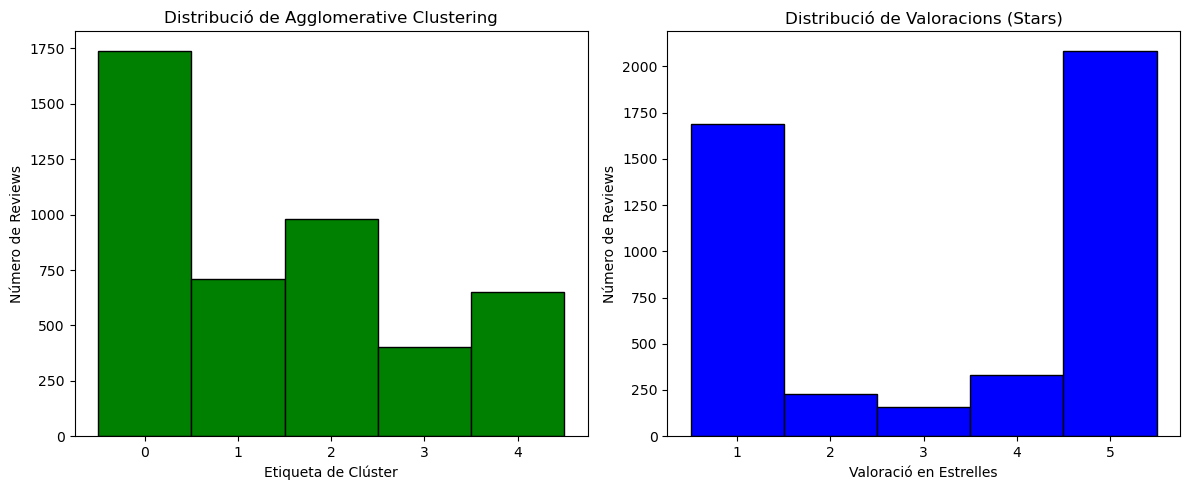

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(agg_labels, bins=range(0, 6), color='green', edgecolor='black', align='left')
axes[0].set_xticks(range(0, 5)) 
axes[0].set_title("Distribució de Agglomerative Clustering")
axes[0].set_xlabel("Etiqueta de Clúster")
axes[0].set_ylabel("Número de Reviews")

axes[1].hist(df["stars"], bins=range(1, 7), color='blue', edgecolor='black', align='left')
axes[1].set_xticks(range(1, 6))  
axes[1].set_title("Distribució de Valoracions (Stars)")
axes[1].set_xlabel("Valoració en Estrelles")
axes[1].set_ylabel("Número de Reviews")

plt.tight_layout()
plt.show()

## Anàlisi dels clusters (3 punts)

Ara que has realitzat el clustering, és moment d'analitzar els resultats obtinguts per poder proporcionar insights al negoci.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> revisa la composició dels clusters. <strong>Per a cada cluster</strong> identificat, has de mostrar de manera clara i organitzada la informació següent:
<ul>
<li><strong>Nombre de reviews</strong> assignades a aquest cluster.
<li><strong>Mitjana d'estrelles</strong> de les reviews dins d'aquest cluster.
<li><strong>Reviews representatives:</strong> selecciona 5 reviews per a cada cluster que permetin tenir una idea general del seu contingut. Si el mètode de clustering utilitzat calcula els centroides (és a dir, el "centre" del cluster), selecciona les 5 reviews més properes al centre per a una representació més precisa.
Si el mètode no calcula centroides, simplement selecciona qualsevol 5 reviews del cluster.
</ul>
</div>

L'últim pas és la interpretació dels clusters mitjançant l'anàlisi de les mostres pertanyents a cada cluster.

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Pots identificar diferents temes o patrons en els missatges de cada cluster? Comenta la temàtica de cada cluster.
</div>